In [157]:
import pandas as pd
import numpy as np
import torch
import sklearn

### Importing data

In [158]:
from sklearn.model_selection import train_test_split

#Read in data
train = pd.read_csv('data/train.csv')
#Remove any rows with missing values
df = train.dropna(axis=0, how='any') # figure out how to bootstrap
#Drop columns
df = df.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN','Num_Credit_Inquiries', 'Payment_Behaviour'], axis=1)

#Drop unimportant columns
df = df.drop(['Monthly_Balance'], axis=1)
# df = df.drop(['Monthly_Balance', 'Num_of_Loan', 'Num_Bank_Accounts', 'Age'], axis=1)

# Testing subsets of n best features
# df = df[['Outstanding_Debt', 'Credit_History_Age', 'Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Credit_Score']]

#Removing extra underscores from columns
df['Age'] = df['Age'].str.replace('_', '')
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '')
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '')
# df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.dropna(axis=0, how='any')


df.drop(df[df['Occupation'] == '_______'].index, inplace=True)
df.drop(df[df['Credit_Mix'] == '_'].index, inplace=True)
df.drop(df[df['Changed_Credit_Limit'] == ''].index, inplace=True)
df.drop(df[df['Payment_of_Min_Amount'] == 'NM'].index, inplace=True)

C:\Users\jtcle\AppData\Local\Temp\ipykernel_14016\1978108155.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


In [159]:
#Finding unique loan types and making a new column for each
unique_loans = set()

for row in df['Type_of_Loan']:
    vals = row.split(',')
    for loan in vals:
        unique = loan.lstrip(' and').strip()
        unique_loans.add(unique)

unique_loans.remove('Not Specified')

temp = pd.DataFrame(columns=list(unique_loans), data=np.zeros(shape=(len(df), len(unique_loans)), dtype=np.int8))
# print(temp)

# Updating the columns with correct loans
for i, row in enumerate(df['Type_of_Loan']):
    for loan in unique_loans:
        temp.at[i, loan] = row.count(loan)

# print(temp)
df = pd.concat([df.drop('Type_of_Loan', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23  Scientist      19114.12            1824.843333                  3   
1      28    Teacher      34847.84            3037.986667                  2   
2      28    Teacher      34847.84            3037.986667                  2   
3      28    Teacher      34847.84            3037.986667                  2   
4      28    Teacher      34847.84            3037.986667                  2   
...    ..        ...           ...                    ...                ...   
33935  28  Architect      20002.88            1929.906667                 10   
33936  28  Architect      20002.88            1929.906667                 10   
33937  29  Architect      20002.88            1929.906667                 10   
33938  25   Mechanic      39628.99            3359.415833                  4   
33939  25   Mechanic      39628.99            3359.415833                  4   

       Num_Credit_Card  Interest_Rate N

In [160]:
#Changing credit history to be in terms of months
#df.dropna(axis=0, how='any', inplace=True)
temp = pd.DataFrame(columns=['Credit_History_Age'], data=np.zeros(shape=(len(df), 1), dtype=np.int8))
zero_count = 0

for i, row in enumerate(df['Credit_History_Age']):
        age_series = row.split(' and ')
        years = int(age_series[0].rstrip('Years').strip())
        months = int(age_series[1].rstrip('Months').strip())
        temp.at[i, 'Credit_History_Age'] = years*12+months

df = pd.concat([df.drop('Credit_History_Age', axis=1).reset_index(drop=True), temp.reset_index(drop=True)], axis=1)

print(df)

      Age Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23  Scientist      19114.12            1824.843333                  3   
1      28    Teacher      34847.84            3037.986667                  2   
2      28    Teacher      34847.84            3037.986667                  2   
3      28    Teacher      34847.84            3037.986667                  2   
4      28    Teacher      34847.84            3037.986667                  2   
...    ..        ...           ...                    ...                ...   
33935  28  Architect      20002.88            1929.906667                 10   
33936  28  Architect      20002.88            1929.906667                 10   
33937  29  Architect      20002.88            1929.906667                 10   
33938  25   Mechanic      39628.99            3359.415833                  4   
33939  25   Mechanic      39628.99            3359.415833                  4   

       Num_Credit_Card  Interest_Rate N

In [161]:
#Get columns ready to encode
encoding_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount']
data_to_encode = df[encoding_columns]


#Creating a OneHotEncoder   
ohe = sklearn.preprocessing.OneHotEncoder()

ohe.fit(data_to_encode)
encoded = ohe.transform(data_to_encode)

#Get feature names
feature_names = ohe.get_feature_names_out(input_features=encoding_columns)
ohe_df = pd.DataFrame.sparse.from_spmatrix(encoded, columns=feature_names)


encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)

final_df = pd.concat([df.drop(encoding_columns, axis=1), encoded_df], axis=1)

print(final_df)
print(final_df.shape)

      Age Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23      19114.12            1824.843333                  3   
1      28      34847.84            3037.986667                  2   
2      28      34847.84            3037.986667                  2   
3      28      34847.84            3037.986667                  2   
4      28      34847.84            3037.986667                  2   
...    ..           ...                    ...                ...   
33935  28      20002.88            1929.906667                 10   
33936  28      20002.88            1929.906667                 10   
33937  29      20002.88            1929.906667                 10   
33938  25      39628.99            3359.415833                  4   
33939  25      39628.99            3359.415833                  4   

       Num_Credit_Card  Interest_Rate Num_of_Loan  Delay_from_due_date  \
0                    4              3           4                    3   
1                    4 

In [162]:
# Change variable types of columns
final_df = final_df.astype({'Age': float, 'Monthly_Inhand_Salary': float, 'Num_of_Loan': float, 'Annual_Income' : float, 'Num_of_Delayed_Payment': float,'Changed_Credit_Limit': float, 'Outstanding_Debt': float, 'Amount_invested_monthly': float})
# final_df = df.astype({'Changed_Credit_Limit': float, 'Outstanding_Debt': float, 'Amount_invested_monthly': float})

In [163]:
to_standardize = ['Annual_Income', 'Monthly_Inhand_Salary', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
              'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date',
              'Num_of_Delayed_Payment', 'Credit_History_Age', 'Age', 'Num_Bank_Accounts', 'Num_of_Loan',]
pd.set_option('display.max_columns', None)
for col in final_df.columns:
    if col in to_standardize:
        final_df[col] = (final_df[col] - final_df[col].mean())/final_df[col].std()

print(final_df)

            Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0     -0.129070      -0.110307              -0.713540          -0.119731   
1     -0.122047      -0.099405              -0.322582          -0.128102   
2     -0.122047      -0.099405              -0.322582          -0.128102   
3     -0.122047      -0.099405              -0.322582          -0.128102   
4     -0.122047      -0.099405              -0.322582          -0.128102   
...         ...            ...                    ...                ...   
33935 -0.122047      -0.109691              -0.679682          -0.061131   
33936 -0.122047      -0.109691              -0.679682          -0.061131   
33937 -0.120643      -0.109691              -0.679682          -0.061131   
33938 -0.126261      -0.096092              -0.218995          -0.111359   
33939 -0.126261      -0.096092              -0.218995          -0.111359   

       Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0           

In [164]:
def numeric_encode(y):
    if y == "Good":
        # return torch.tensor([1, 0, 0]).to(torch.float32)
        return 0
    if y == "Standard":
        # return torch.tensor([0, 1, 0]).to(torch.float32)
        return 1
    # return torch.tensor([0, 0, 1]).to(torch.float32)
    return 2

final_df['Credit_Score'] = list(map(numeric_encode, final_df['Credit_Score'].values))

x = final_df.drop(['Credit_Score'], axis=1).values
y = final_df['Credit_Score'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7)

### Decision Tree

accuracy : 0.6868002357100766
[[ 975  542  105]
 [ 553 3951  893]
 [  89 1007 2067]]


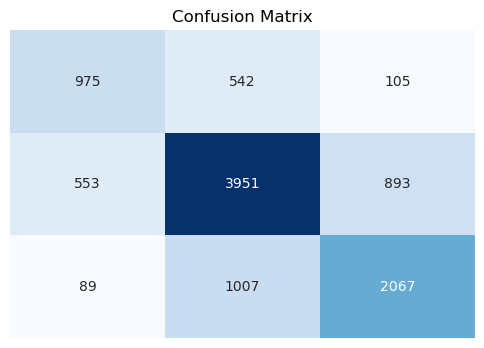

In [165]:
from sklearn import tree, metrics
import seaborn as sns 
import matplotlib.pyplot as plt

# makes a decision tree using x/y train data
dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)

# use model for pred
y_pred_dtc = dtc.predict(x_test)

# getting statistics
accuracy = metrics.accuracy_score(y_test, y_pred_dtc)
# precision = metrics.precision_score(y_test, y_pred_dtc)
# recall = metrics.recall_score(y_test, y_pred_dtc)
# f1 = metrics.f1_score(y_test, y_pred_dtc)
cm = metrics.confusion_matrix(y_test, y_pred_dtc)

print(f'accuracy : {accuracy}')
# print(f'precision : {precision}')
# print(f'recall : {recall}')
# print(f'f1 : {f1}')
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.7703791003732077
[[1142  470   10]
 [ 414 4309  674]
 [  54  716 2393]]


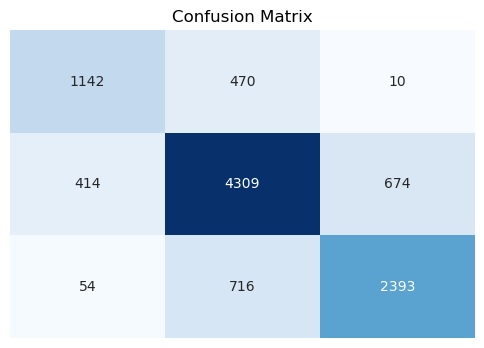

In [166]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc = rfc.fit(x_train, y_train)

y_pred_rfc = rfc.predict(x_test)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)
# precision = metrics.precision_score(y_test, y_pred_rfc)
# recall = metrics.recall_score(y_test, y_pred_rfc)
# f1 = metrics.f1_score(y_test, y_pred_rfc)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)

# Print the results
print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1)
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [167]:
# from sklearn import neighbors
# # Create a KNN classifier and fit it to the training data
# knn = neighbors.KNeighborsClassifier(leaf_size=500)
# knn.fit(x_train, y_train)

# # Predict the labels of the test data
# y_pred_knn = knn.predict(x_test)

# # Calculate the accuracy, precision, recall, and F1 score
# accuracy = metrics.accuracy_score(y_test, y_pred_knn)
# cm = metrics.confusion_matrix(y_test, y_pred_rfc)
# # precision = metrics.precision_score(y_test, y_pred)
# # recall = metrics.recall_score(y_test, y_pred)
# # f1 = metrics.f1_score(y_test, y_pred)

# # Print the results
# print('Accuracy:', accuracy)
# # print('Precision:', precision)
# # print('Recall:', recall)
# # print('F1 score:', f1)
# print(cm)

# # Create a heatmap of the confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
# plt.title('Confusion Matrix')
# plt.show()

In [168]:
#Changing all columns to float type
def to_float(x):
    return torch.tensor(x).to(torch.float32)

training_data = list(zip(map(to_float, x_train), y_train))
test_data = list(zip(map(to_float, x_test), y_test))

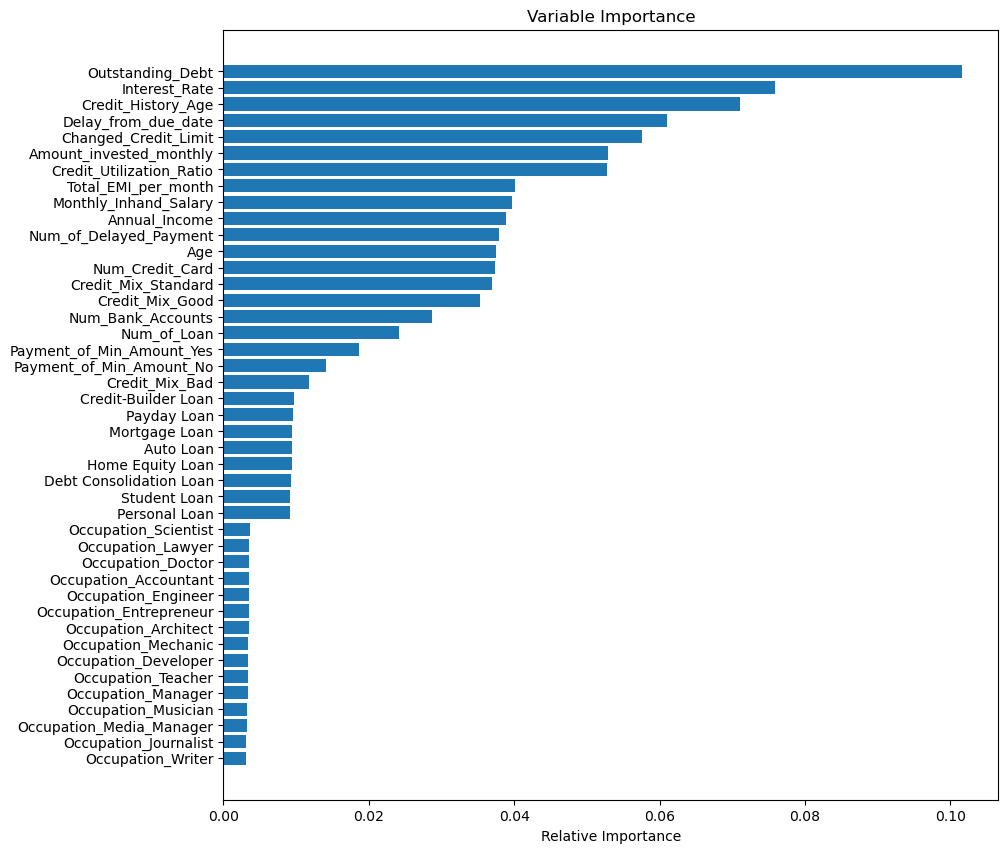

In [169]:
# Feature Selection
features = np.array(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
'Amount_invested_monthly',
'Mortgage Loan', 'Auto Loan', 'Personal Loan',
'Debt Consolidation Loan', 'Home Equity Loan', 'Student Loan',
'Credit-Builder Loan', 'Payday Loan', 'Credit_History_Age',
'Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer',
'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur',
'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
'Occupation_Mechanic', 'Occupation_Media_Manager',
'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
'Occupation_Writer', 'Credit_Mix_Bad', 'Credit_Mix_Good',
'Credit_Mix_Standard', 'Payment_of_Min_Amount_No',
'Payment_of_Min_Amount_Yes'])




# features = np.array(['Outstanding_Debt', 'Credit_History_Age', 'Interest_Rate'])

clf = ensemble.RandomForestClassifier()
clf.fit(final_df[features], final_df['Credit_Score'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features)) + 0.5
plt.figure(figsize=(10, 10))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [226]:
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, drop_last=True)

# choose device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"using {device} device")

# subclass
class NeuralNetwork(nn.Module): # getting stuck at 67%
    def __init__(self):
        super().__init__()
        # Linear Relu Structure
        self.structure = nn.Sequential(
            nn.Linear(43, 256),
            nn.SiLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 3),
        )

        # deeper NN
        # self.structure = nn.Sequential(
        #     nn.Linear(44, 512),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.2),
        #     nn.Linear(512, 1024),
        #     nn.Tanh(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 512),
        #     nn.Sigmoid(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 3),
        # )

        # Fewer nodes
        # self.structure = nn.Sequential(
        #     nn.Linear(43, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 3),
        # )

    def forward(self, x):
        logits = self.structure(x)
        return logits


model = NeuralNetwork().to(device)


using cpu device


In [227]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # print(X.size())
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

y_pred_nn = []
y_actual_nn = []
def test_loop(dataloader, model, loss_fn):
    y_pred_nn.clear()
    y_actual_nn.clear()
    print('ran')
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred_nn.append(pred.max(dim=1).indices)
            y_actual_nn.append(y)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.max(dim=1).indices ==
                        y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# parameters
learning_rate = 0.001
# batch_size = 64
epochs = 50

# implementation
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 1.106500  [   32/23758]
loss: 0.916050  [ 3232/23758]
loss: 0.988539  [ 6432/23758]
loss: 0.798343  [ 9632/23758]
loss: 0.856459  [12832/23758]
loss: 1.013401  [16032/23758]
loss: 0.679970  [19232/23758]
loss: 0.597360  [22432/23758]
ran
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.723833 

Epoch 2
-------------------------------
loss: 0.541785  [   32/23758]
loss: 0.829676  [ 3232/23758]
loss: 0.671066  [ 6432/23758]
loss: 0.738319  [ 9632/23758]
loss: 0.697328  [12832/23758]
loss: 0.654779  [16032/23758]
loss: 0.563458  [19232/23758]
loss: 0.693375  [22432/23758]
ran
Test Error: 
 Accuracy: 66.6%, Avg loss: 0.716033 

Epoch 3
-------------------------------
loss: 0.684150  [   32/23758]
loss: 0.981171  [ 3232/23758]
loss: 0.793542  [ 6432/23758]
loss: 0.992070  [ 9632/23758]
loss: 0.732659  [12832/23758]
loss: 0.852611  [16032/23758]
loss: 0.791592  [19232/23758]
loss: 0.646134  [22432/23758]
ran
Test Error: 
 Accuracy: 68.5%, Avg loss: 0.7

ran
Test Error: 
 Accuracy: 69.8%, Avg loss: 2.018882 



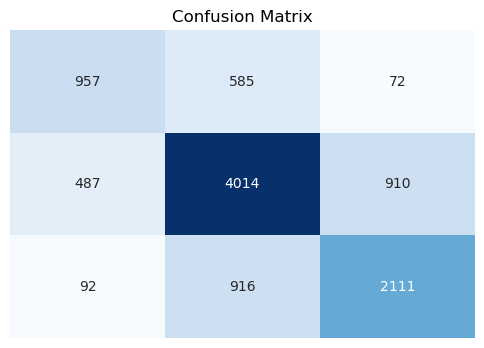

In [138]:
test_loop(test_dataloader, model, loss_fn)
y_pred_nn_cm = torch.flatten(torch.stack(y_pred_nn[:len(y_pred_nn)-1], 0)).cpu().detach().numpy()
y_actual_nn_cm = torch.flatten(torch.stack(y_actual_nn[:len(y_actual_nn)-1], 0)).cpu().detach().numpy()

# print(y_pred_nn)
# print(y_pred_nn)
# print(y_actual_nn.flatten())
cm_nn = metrics.confusion_matrix(y_actual_nn_cm, y_pred_nn_cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='g', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Confusion Matrix')
plt.show()


In [139]:
# save model
torch.save(model.state_dict(), 'credit_score_lin_relu.pth')

In [ ]:
# load model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('credit_score_lin_relu.pth'))
model.eval()  # set to testing mode

NeuralNetwork(
  (structure): Sequential(
    (0): Linear(in_features=44, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): Tanh()
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=3, bias=True)
  )
)